# 프로젝트 :  Segmentation map으로 도로 이미지 만들기
---

## LMS 요구사항

- 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요. (어떠한 방법을 사용했는지 적어주세요.)
- 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.
- 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
- 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
- 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

---
## 루브릭 평가 조건
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
    - 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
    - U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.
    - 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

---
## 목차
>### 1. 데이터 불러오기
>### 2. 데이터 전처리
>> ### 2.1 데이터 Argumentation
>### 3. 생성자 모델 구현하기
>### 4. 판별자 모델 구현하기
>### 5. 모델 학습하기
>### 6. 모델 결과 확인
>### 7. 회고
>### 8. Reference
>### 9. 자기다짐 및 아쉬운 점

---

## 1. 데이터 불러오기

In [1]:
import os
import tensorflow as tf

data_path = os.getenv('HOME')+'/aiffel/exp/16_cgan/data/train/'
val_path = os.getenv('HOME')+'/aiffel/exp/16_cgan/data/val/'
print("train 데이터셋의 갯수 :", len(os.listdir(data_path)))
print("valid 데이터셋의 갯수 :", len(os.listdir(val_path)))

tf.random.set_seed(42)
tf.config.list_physical_devices("GPU")

train 데이터셋의 갯수 : 1000
valid 데이터셋의 갯수 : 5


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- train 데이터와 validataion 데이터셋을 가져왔습니다. 각 길이는 1000, 5개가 있는것을 확인할 수 있습니다.
- random seed를 42로 고정하고 GPU를 사용할 수 있음을 확인할 수 있습니다.

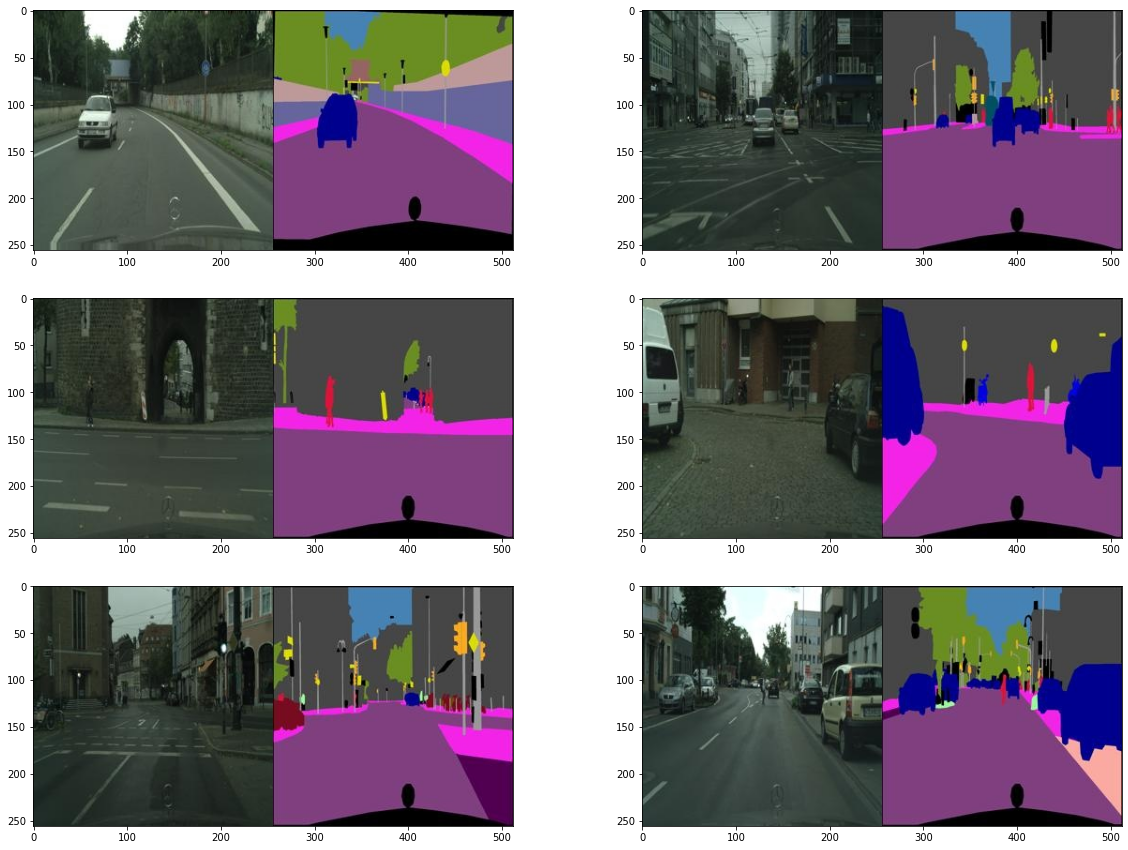

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 랜덤데이터 6개의 이미지를 가져왔습니다. 좌측은 실제 도로이미지 우측은 segmentation 이미지로 되어있군요.

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 256, 512로 이루어져 있으니 256,256 으로 분할해주면 될듯합니다.

---
## 2. 데이터 전처리

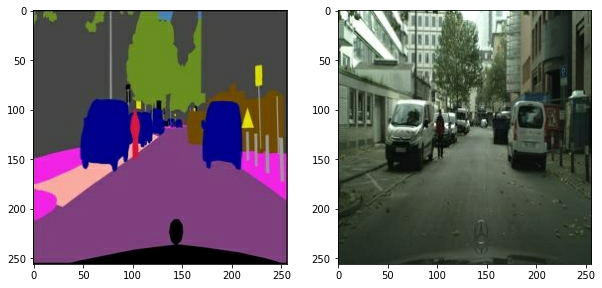

In [4]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    label = img[:, :w, :] 
    label = tf.cast(label, tf.float32)
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32)
    return normalize(label), normalize(seg)

f = data_path + os.listdir(data_path)[1]
label, seg = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(label))

- 정규화 함수와 정규화를 풀어줄 함수도 만들었습니다.
- 또한 이미지를 seg img와 label img로 구분하는 함수도 구현하였습니다.

## 2.1 데이터 Argumentation

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(seg, label):
    stacked = tf.concat([seg, label], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: # uniform : 균일 분포에서 임의의 값을 출력합니다.
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

- 두 데이터를 합친 후 패딩하여 50% 확률로 자르거나 좌우, 상하로 뒤집거나 돌리는 함수입니다.
- 이를 통해 argumentation을 해주도록 하겠습니다.

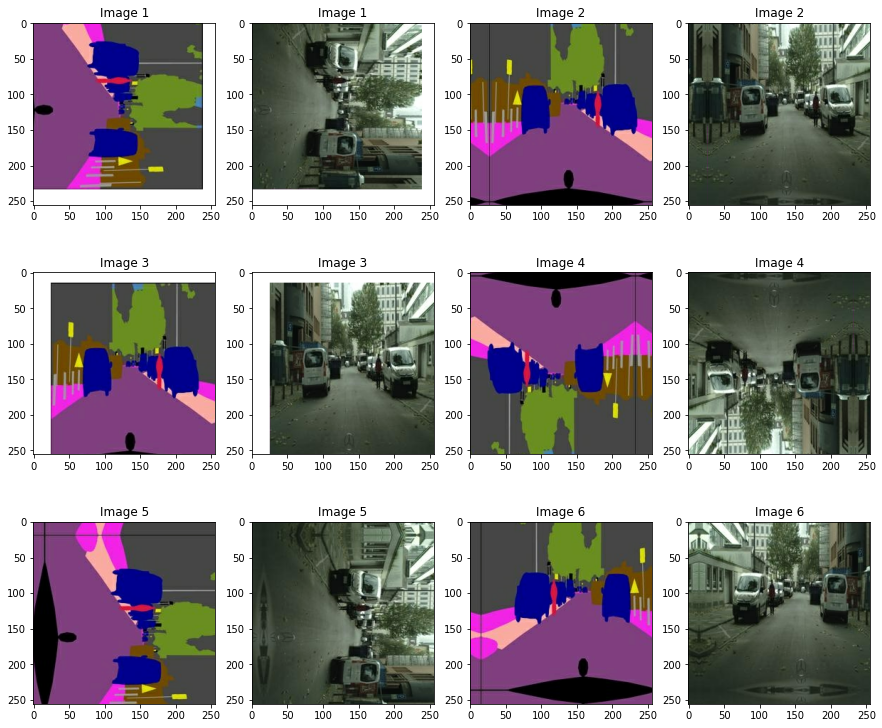

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_label = apply_augmentation(seg, label)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_label)); plt.title(f"Image {img_n}")
    img_n += 1

- argumentation이 잘 진행된 것을 확인할 수 있군요.

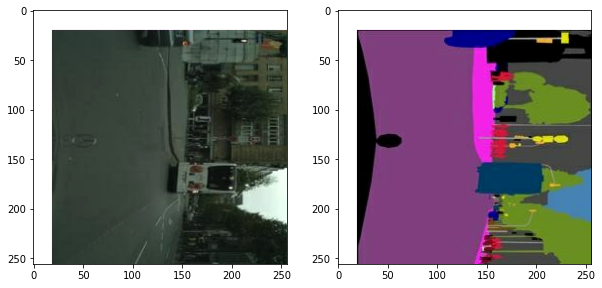

In [7]:
from tensorflow import data

def get_train(img_path):
    label, seg = load_img(img_path)
    seg, label = apply_augmentation(seg, label)
    return seg, label

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(len(os.listdir(data_path))).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
label, seg = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(label[0].astype(np.uint8))

- 모든 이미지를 불러와 argumentation을 해주고 shuffle은 데이터의 길이로 하였고 batch 4로 지정하였습니다.

---
## 3. 생성자 모델 구현하기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2) # slope coefficient(=0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [9]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- 논문을 베이스로하여 encoder, decoder block을 만들고 그것을 통해 unet generator를 만들었습니다.

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

- 약 5400만개의 파라미터를 가진 생성자 모델이 구현되었습니다.

---
## 4. 판별자 모델 구현하기

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

- 위와 같은 방법을 통해 논문을 베이스로한 판별자 모델을 생성하였습니다.

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

- 약 270만개의 파라미터를 가진 판별자 모델이 구현되었군요.

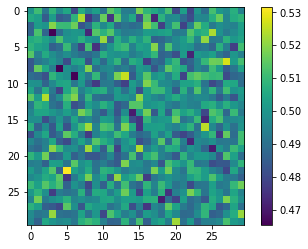

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- 임의의 노이즈 데이터를 넣어보니 구현이 잘 되는것을 볼 수 있습니다.

---
## 5. 모델 학습하기

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

- 논문을 베이스로한 train_step과 loss, optimizer 를 생성해주었습니다.

In [19]:
import time

EPOCHS = 200
start = time.time()

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (seg, label) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, label)       
    if epoch == 1:
        print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}\
            \n학습 시간: {int(time.time()-start)}초", end="\n\n")    
    elif epoch % 10 == 0:
        print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}\
            \n학습 시간: {int(time.time()-start)}초", end="\n\n")

EPOCH[1]             
Generator_loss:1.1518             
L1_loss:0.1838             
Discriminator_loss:0.6675            
학습 시간: 55초

EPOCH[10]             
Generator_loss:1.9061             
L1_loss:0.1736             
Discriminator_loss:0.4503            
학습 시간: 493초

EPOCH[20]             
Generator_loss:1.5733             
L1_loss:0.1405             
Discriminator_loss:1.3098            
학습 시간: 980초

EPOCH[30]             
Generator_loss:1.9736             
L1_loss:0.1299             
Discriminator_loss:2.3400            
학습 시간: 1468초

EPOCH[40]             
Generator_loss:2.1550             
L1_loss:0.2028             
Discriminator_loss:0.2210            
학습 시간: 1954초

EPOCH[50]             
Generator_loss:0.8581             
L1_loss:0.1939             
Discriminator_loss:0.7171            
학습 시간: 2441초

EPOCH[60]             
Generator_loss:0.9083             
L1_loss:0.1604             
Discriminator_loss:0.9899            
학습 시간: 2927초

EPOCH[70]             
Generator_loss:1

- 시간이 꽤 걸리는군요. 200 epochs 학습을 시켰습니다.

---
## 6. 모델 결과 확인

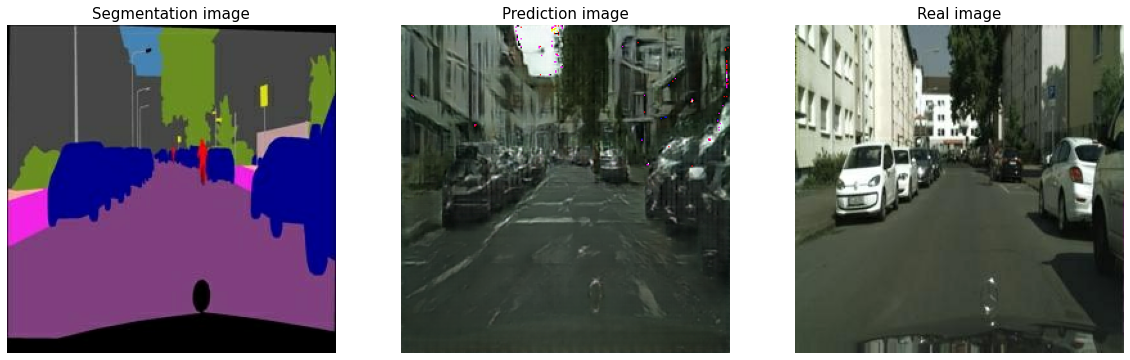

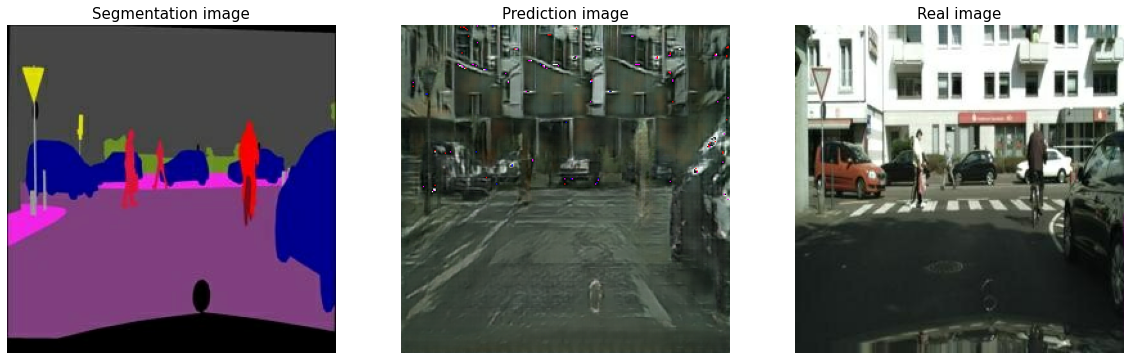

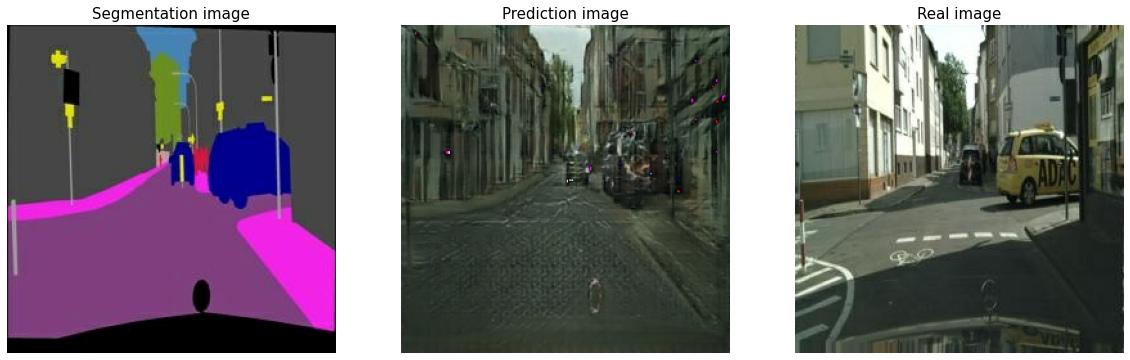

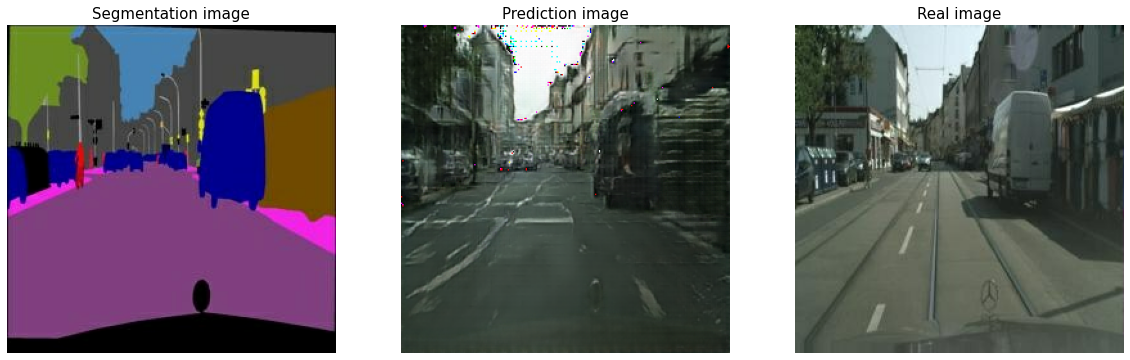

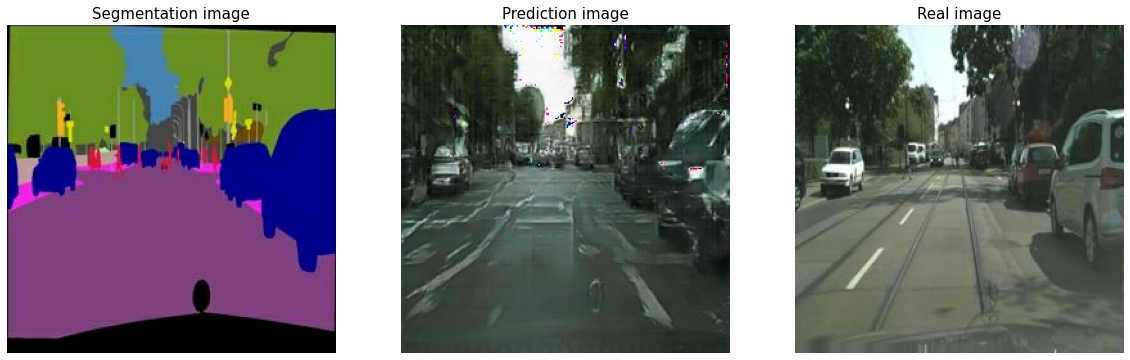

In [20]:
for i in range(len(os.listdir(val_path))):
    f = val_path + os.listdir(val_path)[i]
    label, seg = load_img(f)
    
    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(seg))
    plt.title('Segmentation image', fontsize=15)
    plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.title('Prediction image', fontsize=15)
    plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(denormalize(label))
    plt.title('Real image', fontsize=15)
    plt.axis('off')

- valid 이미지 5장을 가져왔습니다.
- 생각보다 꽤나 좋은 성능을 보여주는군요! 아주 좋습니다.
- 차가 있어야할 곳에 차를 그려주고 도로는 도로, 하늘은 하늘 아주 잘 구분합니다. 하지만 좀 흐릿하고 번지는듯한 이미지인게 좀 아쉽습니다.

---
## 7. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 솔직히 이번 프로젝트는 애매했습니다. LMS에서 준 예시 코드들을 가져와 사용했을 뿐더러 논문에서 가장 좋다는 예시를 사용하니 제가 건들만한 부분이 없어서 딱히 어렵다고 느끼지는 못했고 오히려 건들수가 없는게 가장 어려웠습니다.
### 이번 프로젝트에서 학습한 내용
>- 이번 프로젝트를 통해 그래도 GAN에 대해서는 꽤나 많이 알게된듯 합니다. 성능에 영향을 끼치는 요소나 Argumentation에 관하여 공부는 꽤 하였습니다.
### 알아낸 점이나 모호한 점
>- Argumentation에 대해 공부를 꽤나 많이했는데 위에서 서술했듯 flip, rotation, 밝기, 채도, zoom 등에 관하여 알게 되었습니다.
>- 여전히 사용법은 모호합니다.
### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.__ 에 대해서는 위에서 서술했듯 rotation, flip, crop을 이용하였습니다.
> __2. U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.__ 모델의 구현을 완료하였으며 train_step의 output인 loss들을 중간단계에서 확인하였으며 batch_size, epochs 를 조절하며 개선하였습니다.
> __3. 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.__ 200 epochs를 학습하였으며 테스트 결과 또한 만족스럽게 나왔습니다. 200 epochs 이상 학습시켰을 경우엔 오히려 깨지는 현상이 발생해 200 epochs로 조절하였습니다.
### 루브릭 평가지표를 달성하지 못했다면 이유
>- 2번에서의 train_step의 output을 확인하고 개선하였다. 가 제가 의도한것인지 불분명하여 달성하지 못했다면 2번 루브릭이 아닐까 싶습니다.

---
## 8. Reference

- https://www.tensorflow.org/tutorials/images/data_augmentation 텐서플로우 공식문서 data argumentation
- https://www.tensorflow.org/api_docs/python/tf/random 텐서플로우 공식문서 random 모듈

---
## 9. 자기다짐 및 아쉬운 점

- 이번 프로젝트에서는 많이 학습하지 못한거같아 좀 아쉽습니다. 너무 잘 짜여있는 모델이라서 어떻게 건드려보아도 성능이 나빠지기만하고 건들기가 너무 힘들었습니다.
  
  
- 이제 마지막 exploration이 끝나고 nlp의 going deeper를 하게될텐데 앞으로 잘 할 수 있을지 의문이 듭니다. 지금도 어렵고 힘든데 앞으로 어떻게 해야할지가 막막한 느낌이 듭니다. 그래도 노력할것이니 더 열심히 해봐야겠습니다.